In [ ]:
!zip out.zip test.py train.py 

In [1]:
import json


In [52]:
TRAIN_ANNOTATIONS_PATH = "data/train/new_ann.json"
TRAIN_IMAGE_DIRECTIORY = "data/train/images/"

VAL_ANNOTATIONS_PATH = "data/val/new_ann.json"
VAL_IMAGE_DIRECTIORY = "data/val/images/"

In [47]:
# print(data['annotations'][0].keys())
print(len(data['annotations'][5]['segmentation']))
data['annotations'][5]['bbox']

2


[240.57000000000002, 375.21, 445.4999999999999, 310.85999999999996]

In [45]:
for i in range(len(data['annotations'])):
    for idx in range(len(data['annotations'][i]['segmentation'])):
        data['annotations'][i]['segmentation'][0]
        if (idx == 1):
            print(data['annotations'][i]['bbox']) 
            print(i)


[240.57000000000002, 375.21, 445.4999999999999, 310.85999999999996]
5
[86.42, 77.14, 307.4, 316.68]
47
[210.54, 226.78, 111.35999999999999, 40.599999999999994]
49
[72.5, 72.5, 278.4, 284.20000000000005]
50
[202.42000000000002, 193.14000000000001, 139.2, 84.67999999999998]
51
[60.900000000000006, 60.900000000000006, 314.36, 218.07999999999996]
52
[79.46786708831787, 246.79462524414066, 921.4525, 569.2075]
56
[242.82786708831787, 527.5696252441406, 635.5725, 311.405]
57
[189.7650390625, 207.98875, 430.53621093749996, 412.3125]
67
[7.819999999999999, 7.819999999999999, 483.84, 497.92]
84
[10.38, 10.38, 413.44, 482.56]
85
[48.72, 116.57999999999998, 267.38, 208.8]
87
[136.88, 185.02, 217.5, 176.32000000000002]
88
[14.7, 2.94, 368.48, 388.08]
96
[417.99319896698, 383.1874621582032, 392.6317631912232, 427.4375]
100
[338.24625, 269.02875, 369.16, 438.3775]
107
[253.4140060043335, 269.5475, 352.1825, 403.3375]
119
[160.40125, 171.92875, 183.45749999999998, 212.53]
124
[72.37499999999996, 72.37

In [79]:
from pycocotools.coco import COCO
from pycocotools import mask as mutils
import numpy as np
import pycocotools._mask as _mask
from tqdm.notebook import tqdm
with open(TRAIN_ANNOTATIONS_PATH) as f:
    train_annotations_data = json.load(f)

with open(VAL_ANNOTATIONS_PATH) as f:
    val_annotations_data = json.load(f)
    

train_coco = COCO('data/train/annotations.json')
val_coco = COCO('data/val/annotations.json')

def find_bbox(segm, size_h, size_w):
    rle = {'counts': segm, 'size': [size_h, size_w]}
    compressed_rle = mutils.frPyObjects(segm, rle.get('size')[0], rle.get('size')[1])
    return mutils.toBbox(compressed_rle), mutils.area(compressed_rle)
    

def fix_bbox(data, max_ann, max_id_ann, is_train):
    for n, ann in enumerate(tqdm((data['annotations']))):
        if (n == max_ann):
            return data
        ann_draft = ann
        segm_draft = ann["segmentation"]
        
        img_id = ann["image_id"]
        
        if is_train:
            dict_img = train_coco.loadImgs(img_id)
        else:
            dict_img = val_coco.loadImgs(img_id)

        w = dict_img[0]["width"]
        h = dict_img[0]["height"]
        
        bboxes, area = find_bbox(segm_draft, h, w)
        bboxes = bboxes.tolist()
        for i in range(len(bboxes)):
            bboxes[i] = [bboxes[i][0], bboxes[i][1], bboxes[i][3], bboxes[i][2]]
        area = area.tolist()
        data["annotations"][n]["bbox"], bboxes = bboxes[0], bboxes[1:]
        data["annotations"][n]["segmentation"], segm_draft = [segm_draft[0]], segm_draft[1:]
        data["annotations"][n]["area"], area = area[0], area[1:]
        
        for i in range(len(bboxes)):
            new_ann = {'id': max_id_ann,
             'image_id': ann["image_id"],
             'category_id': ann["category_id"],
             'segmentation': [segm_draft[i]],
             'area': area[i],
             'bbox': bboxes[i],
             'iscrowd': 0
            }
            max_id_ann += 1
            data["annotations"].append(new_ann)
            
    return data

print("Sizes before fixing: ", len(train_annotations_data['annotations']), (len(val_annotations_data['annotations'])))
final_train = fix_bbox(train_annotations_data, len(train_annotations_data['annotations']), 325846, True)
final_val = fix_bbox(val_annotations_data, len(val_annotations_data['annotations']), 325403, False)
print("Sizes after fixing: ", len(final_train['annotations']), (len(final_val['annotations'])))

loading annotations into memory...
Done (t=3.47s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Sizes before fixing:  100256 1708


  0%|          | 0/100256 [00:00<?, ?it/s]

  0%|          | 0/1708 [00:00<?, ?it/s]

Sizes after fixing:  123950 2205


In [80]:
with open('data/train/annotations.json', 'w') as f:
    json.dump(final_train, f)
    
with open('data/val/annotations.json', 'w') as f:
    json.dump(final_val, f)

loading annotations into memory...
Done (t=5.73s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


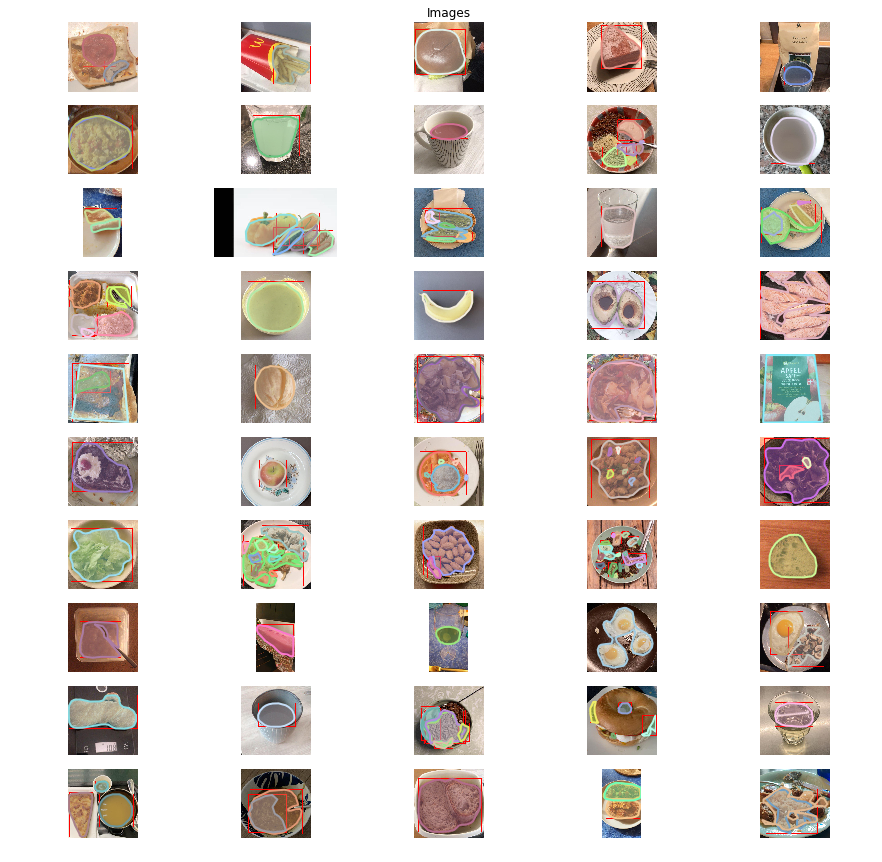

In [82]:
import matplotlib.pyplot as plt
import pandas as pd
import cv2
w, h = 15, 15 # Setting width and height of every image
rows, cols = 10, 5 # Setting the number of image rows & cols

fig = plt.figure(figsize=(15, 15)) # Making the figure with size 

plt.title("Images") 
plt.axis('off')
train_coco = COCO('data/train/annotations.json')
val_coco = COCO('data/val/annotations.json')
img_info = pd.DataFrame(train_coco.loadImgs(train_coco.getImgIds()))
# Going thought every cell in rows and cols
for i in range(1, cols * rows+1):
  annIds = train_coco.getAnnIds(imgIds=img_info['id'][i + 30])
  anns = train_coco.loadAnns(annIds)

  fig.add_subplot(rows, cols, i)

  # Show the image

  img = plt.imread(TRAIN_IMAGE_DIRECTIORY+img_info['file_name'][i + 30])
  for i in anns:
    [x,y,w,h] = i['bbox']
    #create rectagle bbox of size given in dataset
    cv2.rectangle(img, (int(x), int(y)), (int(x+h), int(y+w)), (255,0,0), 2)
  plt.imshow(img)

  # Render annotations on top of the image
  train_coco.showAnns(anns)

  # Setting the axis off
  plt.axis("off")

# Showing the figure
plt.show()